The S&P 500 is a stock market index maintained by S&P Dow Jones Indices. It comprises 503 common stocks which are issued by 500 large-cap companies traded on American stock exchanges (including the 30 companies that compose the Dow Jones Industrial Average).

**yfinance** is a popular open source library .**Yahoo Finance** offers an excellent range of market data on stocks, bonds, currencies and cryptocurrencies.


In [1]:
import yfinance as yf
import pandas as pd
import os

In [2]:
if os.path.exists("sp500.csv"):
    sp500 = pd.read_csv("sp500.csv", index_col=0)
else:
    sp500 = yf.Ticker("^GSPC")
    sp500 = sp500.history(period="max")
    sp500.to_csv("sp500.csv")

In [3]:
sp500.index = pd.to_datetime(sp500.index)


In [4]:
sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
...,...,...,...,...,...,...,...
2024-01-09 00:00:00-05:00,4741.930176,4765.470215,4730.350098,4756.500000,3529960000,0.0,0.0
2024-01-10 00:00:00-05:00,4759.939941,4790.799805,4756.200195,4783.450195,3498680000,0.0,0.0
2024-01-11 00:00:00-05:00,4792.129883,4798.500000,4739.580078,4780.240234,3759890000,0.0,0.0


<Axes: xlabel='Date'>

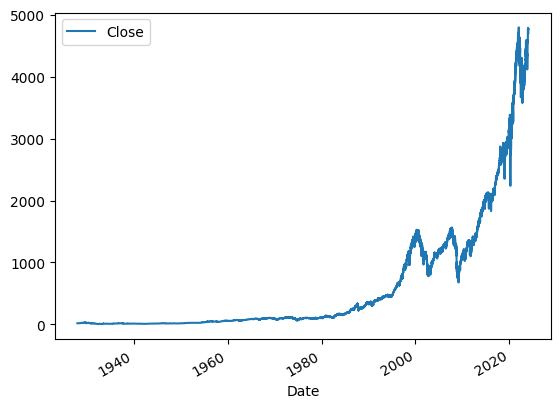

In [5]:
sp500.plot.line(y="Close", use_index=True)


 The value of the S&P 500 index is not a total return index. It doesn't include the gains earned from cash dividends paid by companies to their shareholders.There are total return indexes that track capital gains (stock price increases) as well as dividends.

In [6]:
del sp500["Dividends"]
del sp500["Stock Splits"]

In [7]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)

In [8]:
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)


In [9]:
sp500 = sp500.loc["1990-01-01":].copy()


The **Random forest classifier** creates a set of decision trees from a randomly selected subset of the training set. It is basically a set of decision trees (DT) from a randomly selected subset of the training set. It collects the votes from different decision trees to decide the final prediction.

In [10]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [11]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.5531914893617021

<Axes: xlabel='Date'>

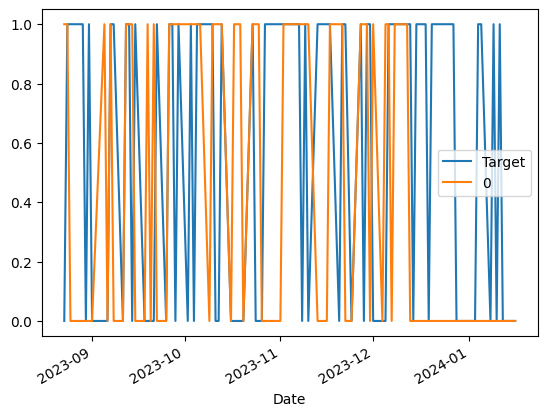

In [12]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [13]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [14]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)

In [15]:
predictions = backtest(sp500, model, predictors)


In [16]:
predictions["Predictions"].value_counts()


0    3479
1    2596
Name: Predictions, dtype: int64

In [17]:
precision_score(predictions["Target"], predictions["Predictions"])


0.5288906009244992

In [18]:
predictions["Target"].value_counts() / predictions.shape[0]


1    0.534321
0    0.465679
Name: Target, dtype: float64

In [19]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()

    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]

    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]

    new_predictors+= [ratio_column, trend_column]

In [20]:
sp500 = sp500.dropna(subset=sp500.columns[sp500.columns != "Tomorrow"])

In [21]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1993-12-14 00:00:00-05:00,465.730011,466.119995,462.459991,463.059998,275050000,461.839996,0,0.997157,1.0,0.996617,1.0,1.000283,32.0,1.028047,127.0,1.176082,512.0
1993-12-15 00:00:00-05:00,463.059998,463.690002,461.839996,461.839996,331770000,463.339996,1,0.998681,0.0,0.995899,1.0,0.997329,32.0,1.025151,126.0,1.172676,512.0
1993-12-16 00:00:00-05:00,461.859985,463.980011,461.859985,463.339996,284620000,466.380005,1,1.001621,1.0,0.999495,2.0,1.000311,32.0,1.028274,127.0,1.176163,513.0
1993-12-17 00:00:00-05:00,463.339996,466.380005,463.339996,466.380005,363750000,465.850006,0,1.003270,2.0,1.004991,3.0,1.006561,32.0,1.034781,128.0,1.183537,514.0
1993-12-20 00:00:00-05:00,466.380005,466.899994,465.529999,465.850006,255900000,465.299988,0,0.999431,1.0,1.003784,2.0,1.005120,32.0,1.033359,128.0,1.181856,513.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-09 00:00:00-05:00,4741.930176,4765.470215,4730.350098,4756.500000,3529960000,4783.450195,1,0.999261,1.0,1.007273,2.0,1.053589,36.0,1.105038,136.0,1.195176,527.0
2024-01-10 00:00:00-05:00,4759.939941,4790.799805,4756.200195,4783.450195,3498680000,4780.240234,0,1.002825,1.0,1.009618,3.0,1.057780,37.0,1.110459,136.0,1.201507,528.0
2024-01-11 00:00:00-05:00,4792.129883,4798.500000,4739.580078,4780.240234,3759890000,4783.830078,1,0.999664,1.0,1.005056,3.0,1.055488,36.0,1.108893,135.0,1.200261,527.0


In [22]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [23]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [24]:
predictions = backtest(sp500, model, new_predictors)


In [25]:
predictions["Predictions"].value_counts()


0.0    4244
1.0     831
Name: Predictions, dtype: int64

In [26]:
precision_score(predictions["Target"], predictions["Predictions"])


0.5728038507821901

In [27]:
predictions["Target"].value_counts() / predictions.shape[0]


1    0.544039
0    0.455961
Name: Target, dtype: float64

In [28]:
predictions

,Target,Predictions
Date,,
2003-11-14 00:00:00-05:00,0,0.0
2003-11-17 00:00:00-05:00,0,1.0
2003-11-18 00:00:00-05:00,1,1.0
2003-11-19 00:00:00-05:00,0,0.0
2003-11-20 00:00:00-05:00,1,1.0
...,...,...
2024-01-09 00:00:00-05:00,1,0.0
2024-01-10 00:00:00-05:00,0,0.0
2024-01-11 00:00:00-05:00,1,0.0
